# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных
- Данные находятся в файле /datasets/autos.csv.  

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

In [1]:
#pip install --upgrade jupyterthemes

In [2]:
#!jt -t chesterish
#jt r #стандартная тема

In [3]:
#!pip uninstall scikit-learn
#!pip install scikit-learn==1.3.2
!pip install -U scikit-learn


In [4]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import time
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor

## Подготовка данных

In [5]:
data = pd.read_csv('/Users/artemmm/Downloads/autos.csv')
data_clear = data.copy()
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

0,12,15 - имеют типы object, хотя должны быть datetime.

In [7]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

**Дубликаты**

In [8]:
print(data.duplicated().sum())
data = data.drop_duplicates()

4


In [9]:
duplic = ['Price','DateCreated','VehicleType','RegistrationYear','Power','Kilometer','Brand','Model','LastSeen']
data[duplic][(data[duplic].duplicated() == True)]

,Price,DateCreated,VehicleType,RegistrationYear,Power,Kilometer,Brand,Model,LastSeen
75603,10000,2016-03-07,wagon,2013,184,60000,volkswagen,golf,2016-03-20 14:16:26
77480,15700,2016-03-16,suv,2011,189,90000,mini,other,2016-03-27 14:16:03
77497,800,2016-03-20,wagon,1993,90,150000,volkswagen,golf,2016-04-06 14:18:24
79663,4299,2016-03-22,coupe,2000,193,150000,bmw,3er,2016-03-24 13:16:10
81624,3799,2016-04-05,small,2003,101,150000,volkswagen,golf,2016-04-07 11:15:46
...,...,...,...,...,...,...,...,...,...
345034,15000,2016-04-03,convertible,1975,0,50000,alfa_romeo,spider,2016-04-05 18:17:30
346637,1800,2016-03-29,sedan,1997,116,150000,bmw,3er,2016-03-31 15:46:50
349989,17999,2016-03-26,wagon,2011,143,90000,audi,a4,2016-04-07 00:17:35
354151,8450,2016-03-28,wagon,2007,140,150000,volkswagen,passat,2016-04-01 04:46:10


Очень странно, что существуют строки, в которых совпадения от цены, мощности и года регистрации до модели, бренда и даты последней активности пользователя. Возможно эти строки и не являются дубликатами, но т.к. их всего 138, лучше удалить. 

In [10]:
data = data.drop(data[duplic][(data[duplic].duplicated() == True)].index.to_list())

**Удаление неинформативных признаков**

In [11]:
data = data.drop(['DateCrawled', 'RegistrationMonth','DateCreated', 'NumberOfPictures', 'PostalCode','LastSeen'], axis = 1)

In [12]:
print(data.duplicated().sum())
data = data.drop_duplicates() #дубликаты не имеют ценности, удаляем

44926


**Выбросы**

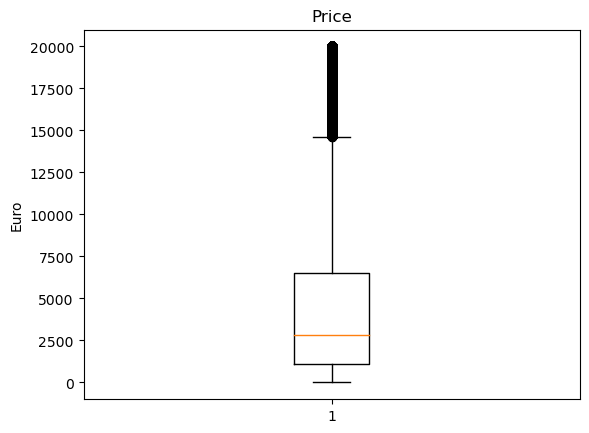

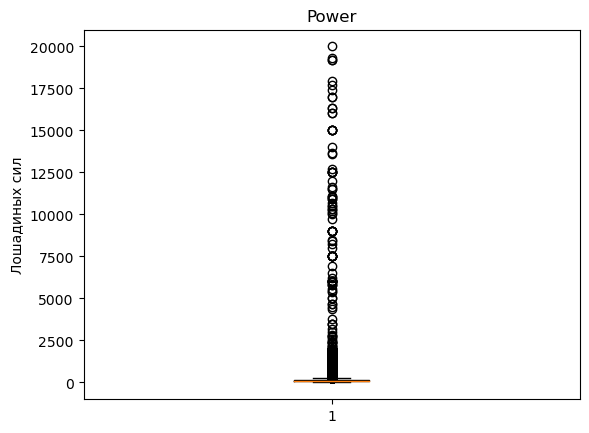

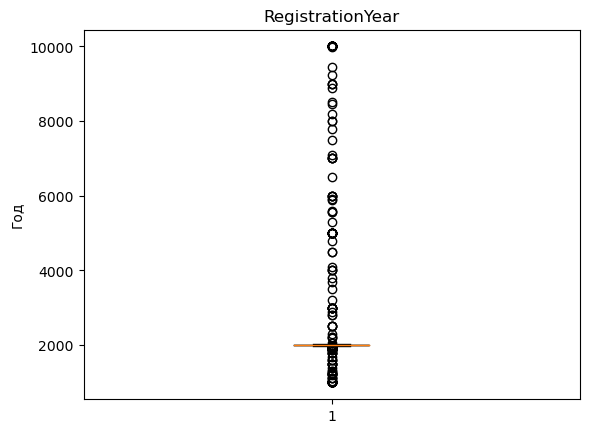

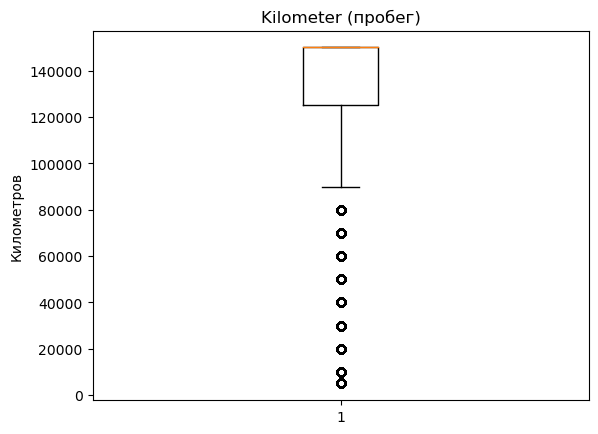

In [13]:
plt.boxplot(data['Price'], vert=True)
plt.title('Price')
plt.ylabel('Euro')
plt.show()
plt.boxplot(data['Power'], vert=True)
plt.title('Power')
plt.ylabel('Лошадиных сил')
plt.show()
plt.boxplot(data['RegistrationYear'], vert=True)
plt.title('RegistrationYear')
plt.ylabel('Год')
plt.show()
plt.boxplot(data['Kilometer'], vert=True)
plt.ylabel('Километров')
plt.title('Kilometer (пробег)')
plt.show()

In [14]:
data_clear['DateCrawled'].max()

'2016-04-07 14:36:58'

In [15]:
print(data.shape[0])
data = data.loc[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] > 1980) ,:]

309301


In [16]:
data = data.loc[data['Price'] < 13000 ,:]

In [17]:
data = data.loc[data['Price'] != 0,:]

In [18]:
data.loc[data['Power'] > 500 ,'Power'] = data['Power'].median()

In [19]:
data = data.loc[data['Power'] != 0,:]

In [20]:
print(data.shape[0])
#если удалить все аномалии, это будет 30% от общего объема данных, столько удалять нельзя. Что-то обрежем вручную, 
#что-то приравняем к медиане

233969


Удалил около 8% данных, некоторые выбросы приравнял к медиане. Т.к. более 10% удалять считается неправильным, то признак с километражем оставим с выбросами. Все таки эти выбросы более реальны, чем 2077 год регистрации автомобиля.

**Пропуски**

Очень много пропусков, для каждого признака нужно искать свой подход борьбы с ними.

In [21]:
data.isna().sum()

Price                   0
VehicleType         10206
RegistrationYear        0
Gearbox              4959
Power                   0
Model                9788
Kilometer               0
FuelType            14550
Brand                   0
Repaired            38071
dtype: int64

In [22]:
null_f = ['Repaired', 'FuelType','VehicleType','Gearbox','Model']
for feat in null_f:    
    print(data[feat].value_counts(), end = '\n \n');
data['VehicleType'] = data['VehicleType'].fillna('NaN') #создаем новую категорию
data['Gearbox'] = data['Gearbox'].fillna('manual') #заполняем модой
data['Repaired'] = data['Repaired'].fillna('no') #заполняем модой
data['FuelType'] = data['FuelType'].fillna('petrol') #заполняем модой
data = data.dropna() #удаляем остальные строки с пропусками

Repaired
no     169724
yes     26174
Name: count, dtype: int64
 
FuelType
petrol      150134
gasoline     64430
lpg           4149
cng            434
hybrid         133
other           74
electric        65
Name: count, dtype: int64
 
VehicleType
sedan          64362
small          57691
wagon          46648
bus            21319
convertible    13910
coupe          10684
suv             6949
other           2200
Name: count, dtype: int64
 
Gearbox
manual    186299
auto       42711
Name: count, dtype: int64
 
Model
golf                  18285
other                 16541
3er                   13170
polo                   8335
corsa                  7657
                      ...  
kalina                    4
amarok                    3
q3                        3
range_rover_evoque        1
rangerover                1
Name: count, Length: 246, dtype: int64
 


**OHE**

In [23]:
data.loc[(data['FuelType'] != 'petrol') &
         (data['FuelType'] != 'gasoline'), 'FuelType'] = 'other'
data.loc[(data['VehicleType'] == 'suv'), 'VehicleType'] = 'other'
models = data['Model'].value_counts().head(40).index.tolist()
data.loc[(~data['Model'].isin(models)), 'Model'] = 'other'
brands = data['Brand'].value_counts().head(20).index.tolist()
data.loc[(~data['Brand'].isin(brands)), 'Brand'] = 'other'

Так как в данных слишком много моделей и брендов авто, а некоторые из них встречаются очень редко, то для увеличения времени обучения модели я создал отдельный тип 'other' для признаков Brand и Model.

## Обучение моделей

**Деление на выборки и OHE**

In [24]:
!pip install --upgrade scikit-learn

In [25]:
data_train, data_test = train_test_split(data, test_size = 0.5, random_state = 2077)
data_test, data_valid = train_test_split(data_test, test_size = 0.5, random_state = 2077)
print(data_train.shape, data_test.shape, data_valid.shape)

(112090, 10) (56045, 10) (56046, 10)


In [26]:
ohe_features_ridge = data_train.select_dtypes(include='object').columns.to_list()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
encoder_ohe.fit(data_train[ohe_features_ridge])

data_train_encoded = encoder_ohe.transform(data_train[ohe_features_ridge])
columns_encoded = encoder_ohe.get_feature_names_out(ohe_features_ridge)
data_train[columns_encoded] = data_train_encoded
data_train = data_train.drop(ohe_features_ridge, axis=1)

data_test_encoded = encoder_ohe.transform(data_test[ohe_features_ridge])
columns_encoded = encoder_ohe.get_feature_names_out(ohe_features_ridge)
data_test[columns_encoded] = data_test_encoded
data_test = data_test.drop(ohe_features_ridge, axis=1)

data_valid_encoded = encoder_ohe.transform(data_valid[ohe_features_ridge])
columns_encoded = encoder_ohe.get_feature_names_out(ohe_features_ridge)
data_valid[columns_encoded] = data_valid_encoded
data_valid = data_valid.drop(ohe_features_ridge, axis=1)

data_train_x = data_train.drop('Price', axis = 1)
data_train_y = data_train['Price']

data_test_x = data_test.drop('Price', axis = 1)
data_test_y = data_test['Price']

data_valid_x = data_valid.drop('Price', axis = 1)
data_valid_y = data_valid['Price']

In [27]:
data_test_x.head()

,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_wagon,...,Brand_other,Brand_peugeot,Brand_renault,Brand_seat,Brand_skoda,Brand_smart,Brand_toyota,Brand_volkswagen,Brand_volvo,Repaired_yes
200256,2000,110,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
255110,2003,75,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
231651,1998,101,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89476,2005,131,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
116682,2003,192,125000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Обучение**

**LightGBM**

In [28]:
best_rmse = 2500
for depth in [4,7, 2,9,10,11]:
    for leaves in [2,3,4,6,8,9]:
        model = LGBMRegressor(num_leaves = leaves, max_depth = depth, random_state = 42)
        model.fit(data_train_x, data_train_y)
        pred = model.predict(data_valid_x)
        rmse = np.sqrt(mean_squared_error(data_valid_y, pred))
        if rmse < best_rmse:
            best_rmse = rmse
            best_leaves = leaves
            best_depth = depth
print('rmse,leaves,depth:',best_rmse, best_leaves, best_depth)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 112090, number of used features: 73
[LightGBM] [Info] Start training from score 3930.875448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 112090, number of used features: 73
[LightGBM] [Info] Start training from score 3930.875448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 112090, number of used features: 73
[LightGBM] [Info] Start training from score 3930.875448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 112090, number of used features: 73
[LightGBM] [Info] Start training from score 3930.875448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

**LinearRegression**

In [29]:
c_features = data_train_x.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler() #масштабирование
scaler.fit(data_train_x[c_features])
data_train_x[c_features] = scaler.transform(data_train_x[c_features])
data_test_x[c_features] = scaler.transform(data_test_x[c_features])
data_valid_x[c_features] = scaler.transform(data_valid_x[c_features])

In [30]:
model = LinearRegression(fit_intercept = True, copy_X = False, n_jobs = -1, positive = False)
model.fit(data_train_x, data_train_y)
pred = model.predict(data_valid_x)
rmse = np.sqrt(mean_squared_error(data_valid_y, pred))
print(rmse)

1917.764649679549


**Краткий вывод: LightGBM показывает лучшие результаты по метрики RMSE (1428) по сравнению с LinearRegression(1917)**

## Анализ моделей

Заказчику важны: качество предсказания, время обучения модели, время предсказания модели.

Я посчитал все эти три критерия в шаге обучения моделей и выяснил, что LightGBM с leaves 9, depth 9 показывает наилучшее время предсказания, время обучения и качество предсказания.

Далее сравним время обучения и предсказания.

In [31]:
from time import time
start = time()
model_gbm = LGBMRegressor(num_leaves = best_leaves, max_depth = best_depth, random_state = 42)
model_gbm.fit(data_train_x, data_train_y)
end1 = time()
pred = model_gbm.predict(data_valid_x)
end2 = time()
rmse = np.sqrt(mean_squared_error(data_valid_y, pred))

print('LGBM')
print('Скорость обучения:', (end1-start)/60, '\nСкорость предсказания', (end2-end1)/60, '\nRMSE =',rmse)

start = time()
model = LinearRegression(fit_intercept = True, copy_X = False, n_jobs = -1, positive = False)
model.fit(data_train_x, data_train_y)
end1 = time()
pred = model.predict(data_valid_x)
end2 = time()
rmse = np.sqrt(mean_squared_error(data_valid_y, pred))
print('\nLinearRegression')
print('Скорость обучения:', (end1-start)/60, '\nСкорость предсказания', (end2-end1)/60, '\nRMSE =',rmse)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 112090, number of used features: 73
[LightGBM] [Info] Start training from score 3930.875448
LGBM
Скорость обучения: 0.008298778533935547 
Скорость предсказания 0.001039417584737142 
RMSE = 1428.1575101950493

LinearRegression
Скорость обучения: 0.009450018405914307 
Скорость предсказания 0.00013899803161621094 
RMSE = 1917.764649679549


В теории, нам подходят обе модели - порог в 2500 RMSE они прошли. Но нужно выбрать лучшую. LGBM показывает 1452 метрики, в то время как более быстрая модель LinearRegression показывает 1929. Скорость обучения у Linear Regression выше в 7 раз, а предсказания - в 4.5 раза. 

Все же, думаю, что лучшим вариантом будет выбор LGBM. Так как разница в метрике значительная.

In [32]:
#test на лучшей модели
pred = model_gbm.predict(data_test_x)
print(np.sqrt(mean_squared_error(data_test_y, pred)))

1452.7059436522884


In [33]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(data_train_x, data_train_y)
d_pred = dummy_regr.predict(data_test_x)
gbm_pred = model_gbm.predict(data_test_x)
print('rmse test:', np.sqrt(mean_squared_error(data_test_y, gbm_pred)), 
     '\nrmse constant:', np.sqrt(mean_squared_error(data_test_y, d_pred)))

rmse test: 1452.7059436522884 
rmse constant: 3274.0250712192897


**Вывод:**
В ходе данной работы были произведены действия:
- масштабирование данных
- OHE категориальных признаков
- Деление на выборки
- Работа с пропусками
- Работа с аномалиями
- Изменение типа признаков
- Обучение на двух моделях
- Предсказание на тестовой выборке
- Определение лучшей модели
- Подбор гиперпараметров

Я построил модель, которая может определять рыночную цену автомобиля. Изначально была проведена отчистка и подготовка данных, после чего я приступил к обучению моделей и подбору гиперпараметров: LinearRegression и LightGBM.

Работа показала, что по критериям заказчика лучше всего подходит модель LightGBM с параметрами depth = 9, num_leaves = 9. Модель прошла порог в 2500 результата, показав результат 1452.70 метрики RMSE.

Лучшая модель LightGBM прошла проверку на адекватность с константной моделью, const = 3274rmse, LightGBM = 1452rmse.